<a href="https://colab.research.google.com/github/tusharsingh-spring/machine-learning-new/blob/main/edi1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit.aer qiskit-machine-learning

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mathchi/diabetes-data-set")

print("Path to dataset files:", path)

100%|██████████| 8.91k/8.91k [00:00<00:00, 20.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1


In [ ]:
import os
os.listdir(path)


['diabetes.csv']

In [ ]:
!pip install qiskit qiskit-aer qiskit-machine-learning --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from qiskit_aer import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [ ]:

data = pd.read_csv(path +"/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


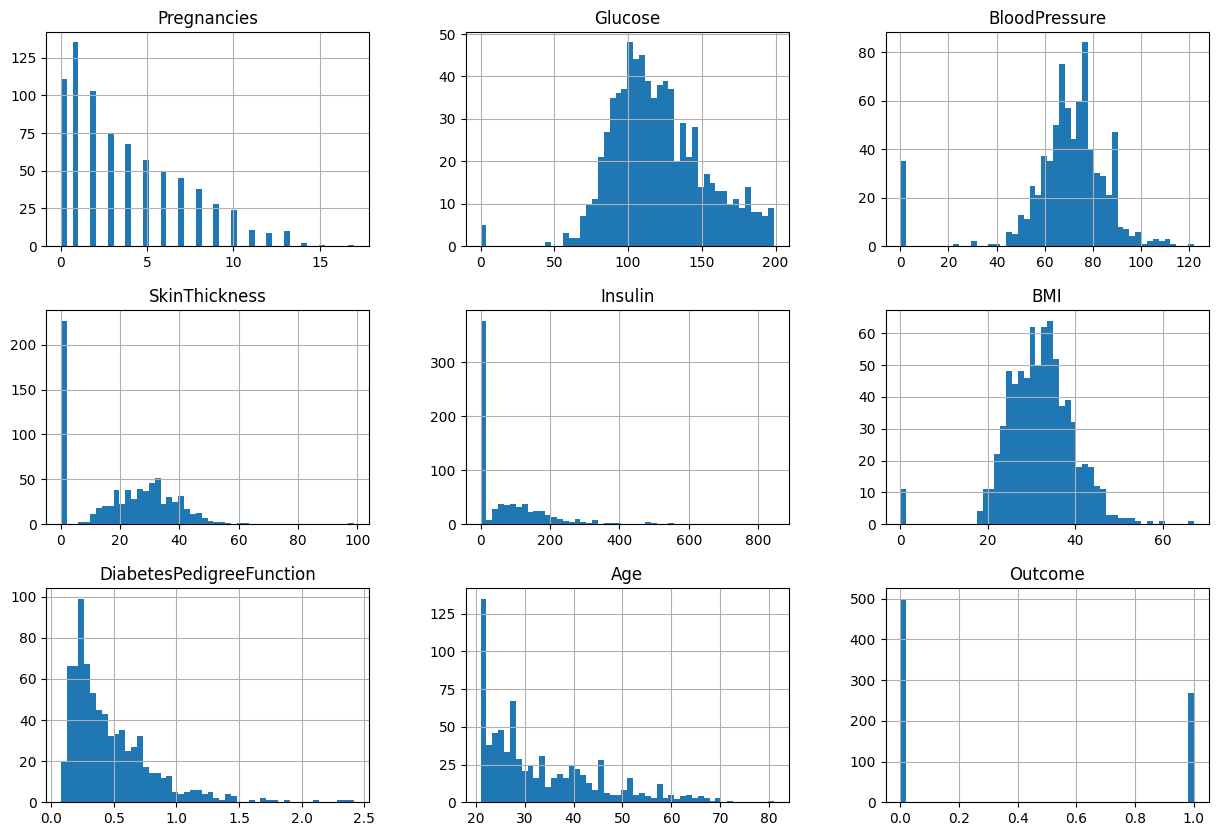

In [ ]:
data.hist(bins=50, figsize=(15,10))
plt.show()

In [ ]:
# Normalize the input features first (important for fair weighting)
from sklearn.preprocessing import MinMaxScaler

cols = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[cols])

# Create DataFrame for ease
scaled_df = pd.DataFrame(scaled_features, columns=cols)

# Assign custom weights (these are just examples — you can tweak based on correlation or domain knowledge)
weights = {
    'Glucose': 0.4,
    'BMI': 0.3,
    'Age': 0.2,
    'DiabetesPedigreeFunction': 0.1
}

# Create the super-indicator
data['SuperIndicator'] = (
    scaled_df['Glucose'] * weights['Glucose'] +
    scaled_df['BMI'] * weights['BMI'] +
    scaled_df['Age'] * weights['Age'] +
    scaled_df['DiabetesPedigreeFunction'] * weights['DiabetesPedigreeFunction']
)

In [ ]:
X= data.iloc[:,:-1].values
y= data['Outcome'].values

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X= scaler.fit_transform(X)
X = data.drop("Outcome", axis=1)  # All input features
y = data["Outcome"]

In [ ]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_pca,y,test_size=0.1,random_state=2)

In [ ]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

In [ ]:
classifier = QSVC(quantum_kernel=quantum_kernel)
classifier.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x7a10064cd6a0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test,y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

           0       0.71      0.98      0.83        51
           1       0.86      0.23      0.36        26

    accuracy                           0.73        77
   macro avg       0.79      0.61      0.60        77
weighted avg       0.76      0.73      0.67        77



In [ ]:
def predict_diabetes(new_data):
    new_data_normalized = scaler.transform(new_data)
    new_data_reduced = pca.transform(new_data_normalized)
    prediction = classifier.predict(new_data_reduced)
    return 'Positive' if prediction[0] == 1 else 'Negative'

In [ ]:

import pandas as pd

comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred

})

print(comparison.head(1))

   Actual  Predicted
0       0          0


In [ ]:
df_test_results = pd.DataFrame(X_test)

df_test_results['Actual'] = y_test
df_test_results['Predicted'] = y_pred

df_test_results.head(20)

,0,1,2,3,Actual,Predicted
0,-1.087134,-0.833312,0.917782,-0.236010,0,0
1,-1.049178,0.252682,0.315978,-0.448150,0,0
2,0.158935,-1.557748,1.248654,-0.439693,0,0
3,-0.546527,0.976595,0.319015,-0.312375,1,0
4,2.409057,-0.458246,0.839527,-0.738318,1,0
5,-0.725152,-1.077796,0.460407,-0.650662,0,0
6,-1.018450,-1.238128,0.464980,0.242677,0,0
7,-0.751283,0.327098,-0.504106,-0.977940,0,1
8,-2.152271,0.269787,0.449144,0.214460,0,0
9,0.250176,-0.109782,-0.424379,-1.180838,1,0


In [ ]:
new_data= np.array([[-0.75,0.32,-0.5,-0.9,7,7,7,7]])
print(predict_diabetes(new_data))

Positive


In [ ]:
df1= pd.read_csv(path +"/diabetes.csv")
print(df1.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [ ]:
corr_matrix = data.corr()

# Get correlations with the 'Insulin' column, sorted
insulin_corr = corr_matrix["Glucose"].sort_values(ascending=False)

# Print the full correlation matrix (optional)
print(corr_matrix)

# Print the sorted correlations with 'Insulin'
print("\nCorrelations with 'Insulin':")
print(insulin_corr)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.033523   
Glucose                   0.331357  0.221

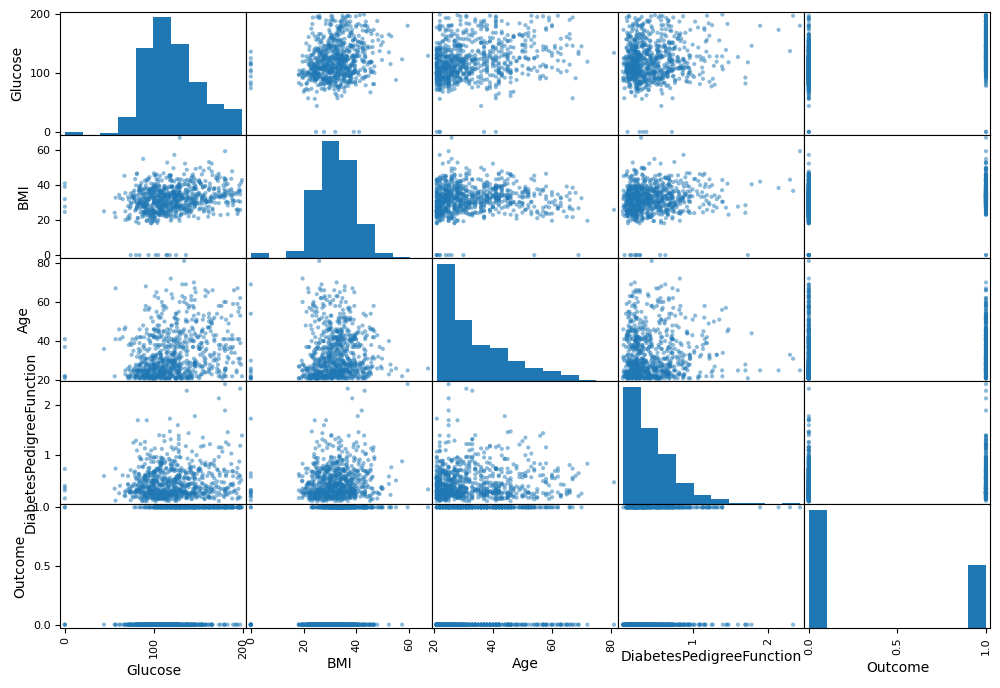

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["Glucose","BMI","Age","DiabetesPedigreeFunction","Outcome"]
scatter_matrix(data[attributes], figsize=(12,8))
plt.show()